In [ ]:
# Change this if you created the shortcut in a different location
path_name = '/content/drive/My Drive/Side projects/Multi instance learning/cropped'
#path_name = "/content/drive/My Drive/Side projects/Multi instance learning/CheXpert-v1.0-small"

# Loading and preprocessing data

In [ ]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    AUX_DATA_ROOT = Path(path_name)
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms

class CXRDataset(Dataset):
    
    def __init__(self, csv_path, n_images):
        data = pd.read_csv(csv_path, usecols=['Path', 'No Finding'], nrows=n_images)
        self.root_path = AUX_DATA_ROOT.parents[0]
        self.labels = data.loc[:, 'No Finding'].fillna(0)
        self.images = data.loc[:, 'Path']
        self.len_dataset = n_images
        size = 320
        self.transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
        '''scale = Rescale(256)
        crop = RandomCrop(128)
        composed = transforms.Compose([Rescale(256),
                                      RandomCrop(224)])''' #todo

    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, idx):
        #return self.transform(self.pil_loader(self.root_path.joinpath(self.images[idx]))), torch.tensor(self.labels[idx])
        return self.transform(self.pil_loader(self.root_path.joinpath(self.images[idx].replace('CheXpert-v1.0-small', 'cropped')))), torch.tensor(self.labels[idx])

    def pil_loader(self, path):
      # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
      with open(path, 'rb') as f:
          img = Image.open(f)
          return img.convert('RGB')

In [ ]:
from torch.utils.data import DataLoader

train_csv_path = AUX_DATA_ROOT.joinpath('train.csv')
valid_csv_path = AUX_DATA_ROOT.joinpath('valid_small.csv')

train_dataset = CXRDataset(train_csv_path, n_images=100)
val_dataset = CXRDataset(valid_csv_path, n_images=20)

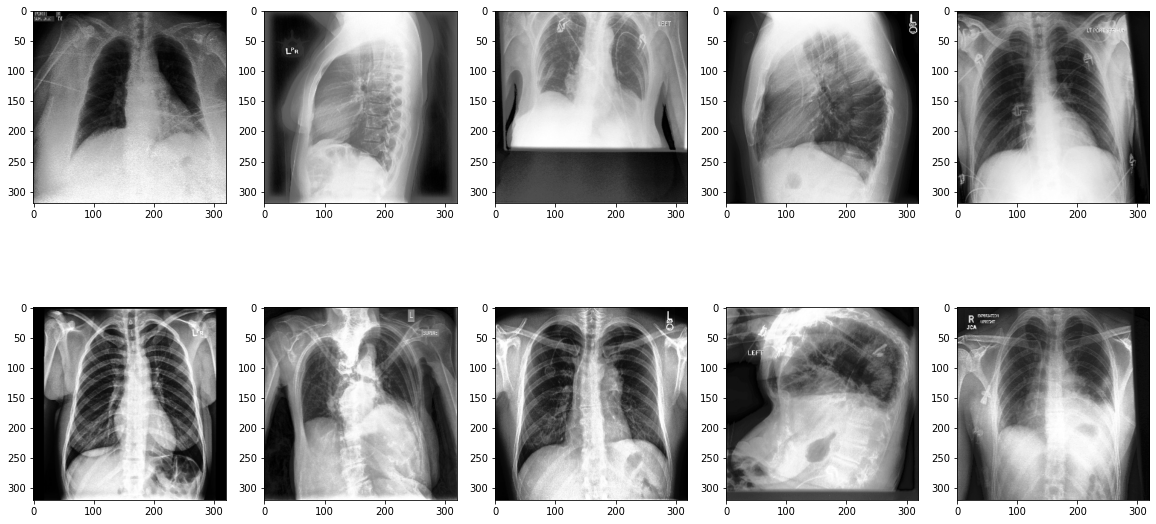

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
fig,ax = plt.subplots(2, 5, figsize=(20, 10))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
for i, (image, target) in enumerate(train_loader):
  if i >= 10:
    break
  ax[i%2, i%5].imshow(np.asarray(image[0, 0, :]), cmap='gray')

# Defining and training the model

In [ ]:
! pip install patchify

     |████████████████████████████████| 12.4MB 248kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from patchify import patchify
import torchvision.models as models

class cxr_model(nn.Module):

  def __init__(self):
    super().__init__()

    self.cnn = models.vgg16(pretrained=True)
    for i in range(15):
      for param in self.cnn.features[i].parameters():
        param.requires_grad = False
    self.cnn.classifier[6] = nn.Linear(self.cnn.classifier[6].in_features, 1)

  def forward(self, x):

    #divide image x into set of overlapping patches of size suitable for a CNN model pre-trained on ImageNet
    x = np.array(x.cpu())
    patches = torch.from_numpy(patchify(x, (1, 3, 224, 224), step=16)).double().cuda() #todo implement for pytorch tensors

    patches = patches[0, 0, :, :, 0]
    patches = patches.reshape(-1, patches.size(2), patches.size(3), patches.size(4))

    x = self.cnn(patches)

    probabilities = torch.softmax(x, dim=0)

    x = torch.max(probabilities).flatten()

    return x

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from time import time
from sklearn.metrics import roc_auc_score

class TrainingModule:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, epochs, scheduler = None, checkpoint = True, early_stop = False):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.scheduler = scheduler
        self.checkpoint = checkpoint
        self.early_stop = early_stop
        self.DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    def train(self):
        list_train_loss = []
        list_val_loss = []

        list_train_auc = []
        list_val_auc = []
        
        best_val_loss = float('+inf')
        
        self.model.to(self.DEVICE)
        self.criterion = self.criterion.to(self.DEVICE)
        
        for epoch in range(self.epochs):
          
            start_time = time()

            train_loss, train_auc = self.run_epoch(dataloader = self.train_loader, mode='train')
            val_loss, val_auc = self.run_epoch(dataloader = self.val_loader, mode='val')

            list_train_loss.append(train_loss)
            list_val_loss.append(val_loss)

            list_train_auc.append(train_auc)
            list_val_auc.append(val_auc)

            # checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                
                if self.checkpoint:
                    torch.save(self.model.state_dict(), './best_model.pth')
            
            if self.scheduler is not None:
                self.scheduler.step(train_loss)

            if (epoch+1) % 1 == 0:
              print('Epoch {}: train loss - {}, train auc - {}'.format(epoch+1, round(train_loss,5), train_auc))
              print('Epoch {}: val loss - {}, val auc - {}'.format(epoch+1, round(val_loss,5), val_auc))
              print ('Elapsed time: %.3f' % (time() - start_time))
              print('----------------------------------------------------------------------')
            
        return list_train_loss, list_val_loss, list_train_auc, list_val_auc


    def run_epoch(self, mode, dataloader):
      
        if mode == 'train':
            self.model.train()
        else:
            self.model.eval()

        epoch_loss = 0.0
        epoch_probs = []
        epoch_labels = []
        
        num_batches = 0
        for vector, target in dataloader:
            vector = vector.to(self.DEVICE)
            target = target.double().to(self.DEVICE)
            
            prediction = self.model(vector)
            loss = self.criterion(prediction, target)
            
            if mode == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            epoch_loss += loss.item()
            epoch_probs.append(prediction.detach().item())
            epoch_labels.append(target.item())

            num_batches += 1
            
            if self.early_stop:
                break

            print(mode+' batch {}: loss - {}'.format(num_batches, round(loss.item(),5)))
            print('----------------------------------------------------------------------')
        
        num_batches = float(num_batches)

        auc = roc_auc_score(epoch_labels, epoch_probs)

        return epoch_loss/num_batches, auc

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import random 

batch_size = 1
lr = 1e-5
wd = 1e-6

SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #todo True
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
model = cxr_model().double()

########################################################################################
N_EPOCHS = 250
LR = lr

optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=wd, momentum=0.9, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True)
criterion = nn.BCELoss()

train_class = TrainingModule(model, optimizer, criterion, train_loader, val_loader, N_EPOCHS)
list_train_loss, list_val_loss, list_train_auc, list_val_auc = train_class.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



train batch 1: loss - 3.30502
----------------------------------------------------------------------
train batch 2: loss - 0.03499
----------------------------------------------------------------------
train batch 3: loss - 0.04407
----------------------------------------------------------------------
train batch 4: loss - 0.04232
----------------------------------------------------------------------
train batch 5: loss - 0.03479
----------------------------------------------------------------------
train batch 6: loss - 3.35827
----------------------------------------------------------------------
train batch 7: loss - 3.13582
----------------------------------------------------------------------
train batch 8: loss - 3.15515
----------------------------------------------------------------------
train batch 9: loss - 3.32857
----------------------------------------------------------------------
train batch 10: loss - 0.03723
-----------------------------------------------------------

In [ ]:
model

# Evaluating performance

In [ ]:
model = cxr_model()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

In [ ]:
with torch.no_grad():
  for vector, target in val_loader:
    val_predicted = model(vector)
    target = target
  print (torch.mean(torch.abs(val_predicted-target)))